In [45]:
import json
import os
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

In [46]:
def get_vocab_size_dict_from_folder(folder, prefix_filter = None):
    tokenizer_paths_folder = Path(folder)

    if prefix_filter == None:
        subfolders = [f for f in tokenizer_paths_folder.iterdir() if f.is_dir()]
    else:
        subfolders = [f for f in tokenizer_paths_folder.iterdir() if f.is_dir() and f.name.startswith(prefix_filter)]

    vocabularies = []
    for subfolder in tqdm(subfolders):
        tokenizer_path = subfolder / 'tokenizer.json'
        if tokenizer_path.exists():
            with open(tokenizer_path, 'r') as f:
                
                tokenizer_data = json.load(f)
            tokens = tokenizer_data['model']['vocab']
            vocabularies.append(tokens)

    vocab_size_dict = {}
    vocab_sizes = []
    for vocab in tqdm(vocabularies):
        vocab_size = len(vocab)
        vocab_sizes.append(vocab_size)
        token_lengths = [len(token) for token in vocab.keys() if len(token) <= 20]
        vocab_size_dict[vocab_size] = token_lengths


    vocab_size_dict = dict(sorted(vocab_size_dict.items()))

    return vocab_size_dict


small_data_vocab = get_vocab_size_dict_from_folder('./tokenizers', 'size_')
big_data_vocab = get_vocab_size_dict_from_folder('./tokenizers/wikipedia', 'size_')

small_keys = list(small_data_vocab.keys())
big_keys = list(big_data_vocab.keys())

joint_keys = list(set(small_keys).intersection(set(big_keys)))
joint_keys.sort()


100%|██████████| 65/65 [00:00<00:00, 142.60it/s]


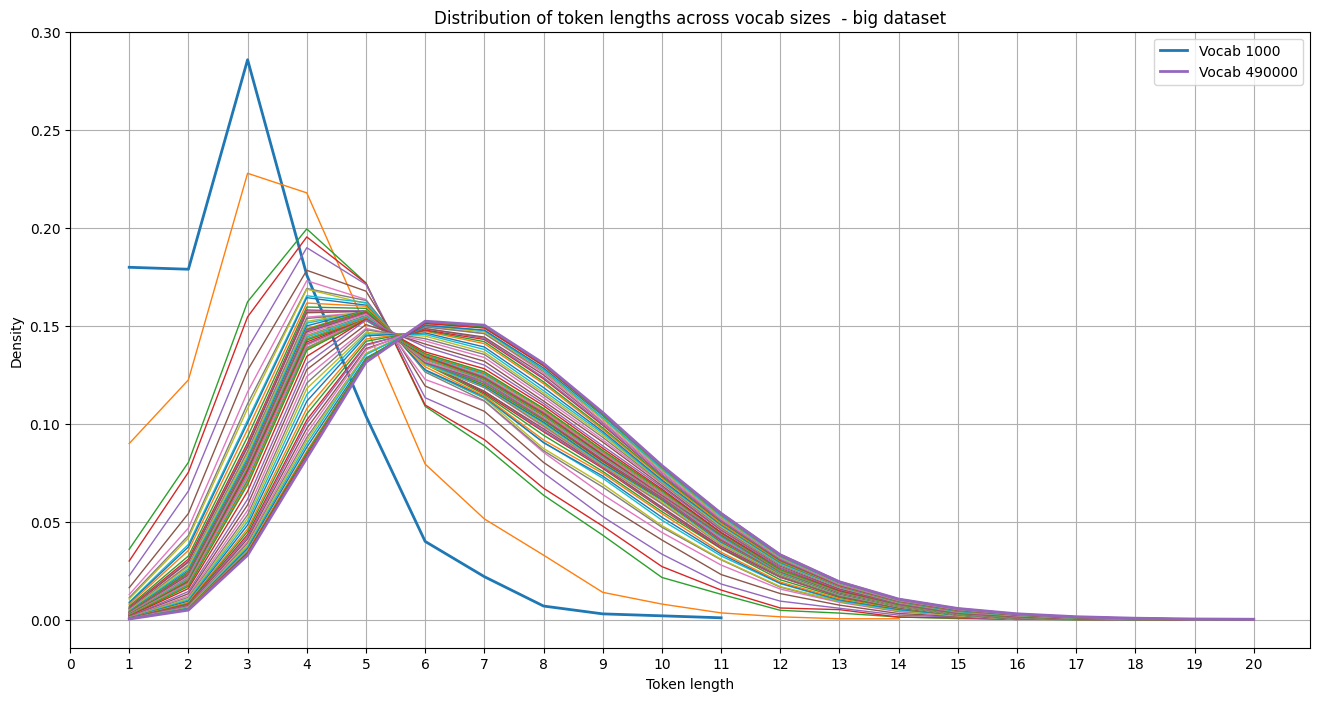

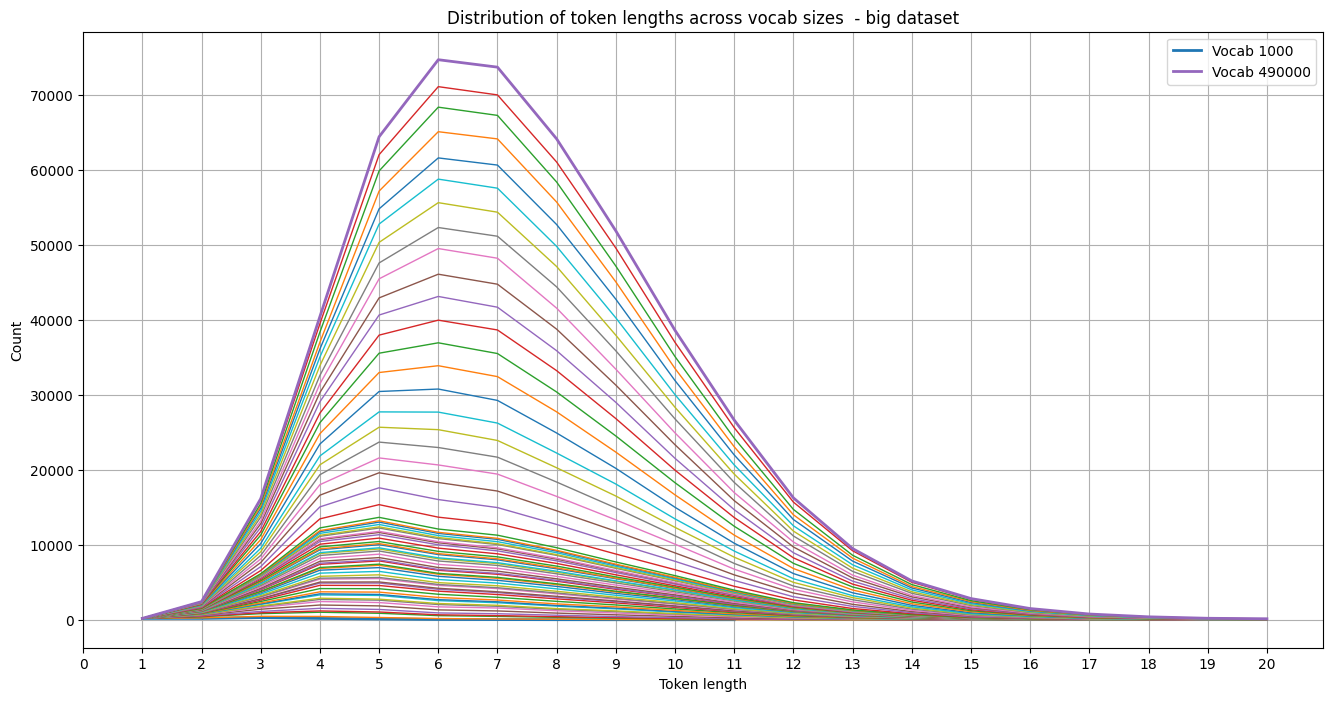

In [47]:
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt


def plot_distributions(vocab_size_dict, filename = None, relative = False, title_suffix = ""):
    smallest_vocab_len = min(vocab_size_dict.keys())
    biggest_vocab_len = max(vocab_size_dict.keys())

    plt.figure(figsize=(16, 8))
    for vocab_len, token_lengths in vocab_size_dict.items():
        # build (x,y)
        counts = Counter(token_lengths)
        xs = np.array(sorted(counts))
        if relative:
            ys = np.array([counts[x] for x in xs]) / sum(counts.values())
        else:
            ys = np.array([counts[x] for x in xs])

        # piecewise linear line
        if vocab_len in [smallest_vocab_len, biggest_vocab_len]:
            plt.plot(xs, ys, label=f"Vocab {vocab_len}", linewidth=2)
        else:
            plt.plot(xs, ys, linewidth=1)

    plt.title(f"Distribution of token lengths across vocab sizes {title_suffix}")
    plt.xlabel("Token length")
    if relative:
        plt.ylabel("Density")
    else:
        plt.ylabel("Count")
    plt.legend()
    plt.xticks(range(0, 21, 1))
    plt.grid(True)
    if filename is not None:
        plt.savefig(os.path.join("images", filename), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

plot_distributions(big_data_vocab, filename = "big_data_relative.png", relative=True, title_suffix=" - big dataset")
plot_distributions(big_data_vocab, filename = "big_data_nonrelative.png", relative=False, title_suffix=" - big dataset")

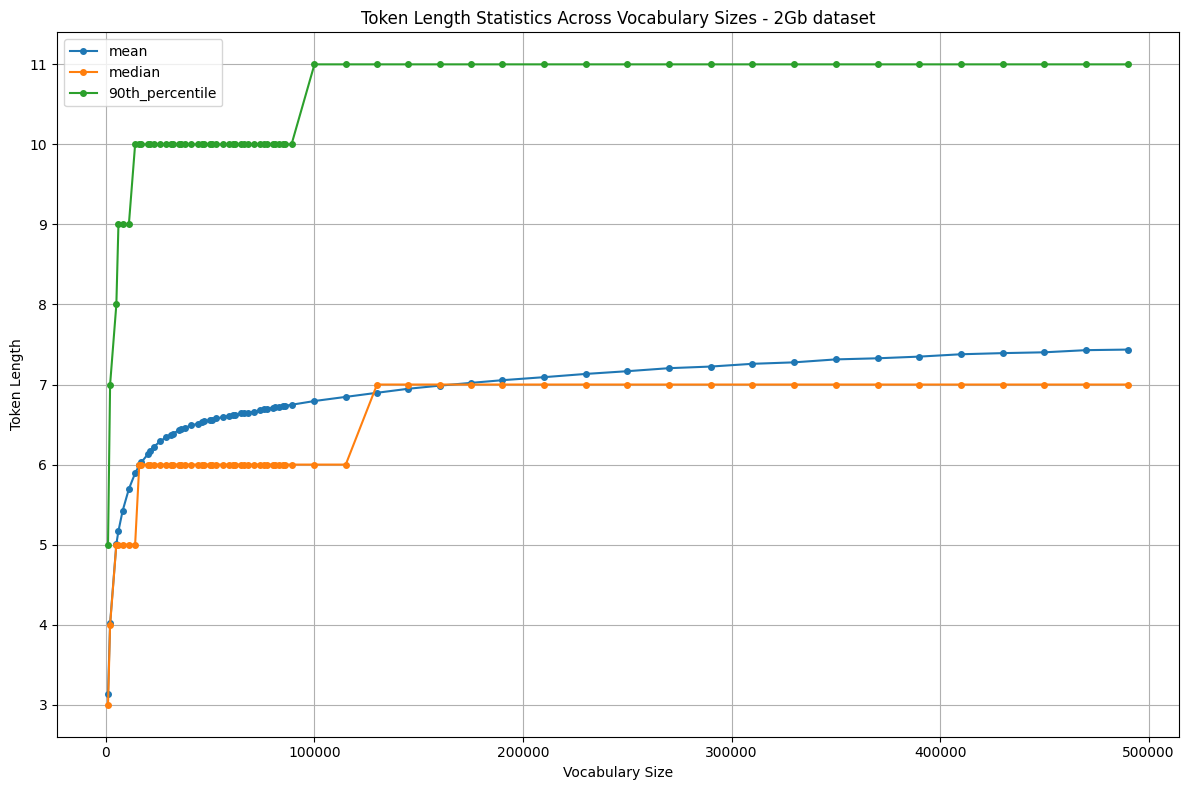

In [48]:
def create_statistics_plot_for_vocabulary_dict(vocab_size_dict, output_filename = None, ignore_max = True):
    stats = {
        'max': [],
        'mean': [],
        'median': [],
        '90th_percentile': []
    }
    vocab_sizes = []

    for vocab_len, token_lengths in vocab_size_dict.items():
        vocab_sizes.append(vocab_len)
        stats['max'].append(max(token_lengths))
        stats['mean'].append(np.mean(token_lengths))
        stats['median'].append(np.median(token_lengths))
        stats['90th_percentile'].append(np.percentile(token_lengths, 90))

    if ignore_max:
        stats.pop('max', None)

    # Create the plot
    plt.figure(figsize=(12, 8))

    for stat_name, values in stats.items():
        plt.plot(vocab_sizes, values, label=stat_name, marker='o', markersize=4)

    plt.title("Token Length Statistics Across Vocabulary Sizes - 2Gb dataset")
    plt.xlabel("Vocabulary Size")
    plt.ylabel("Token Length")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if output_filename:
        plt.savefig(os.path.join("images", output_filename), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

create_statistics_plot_for_vocabulary_dict(big_data_vocab)


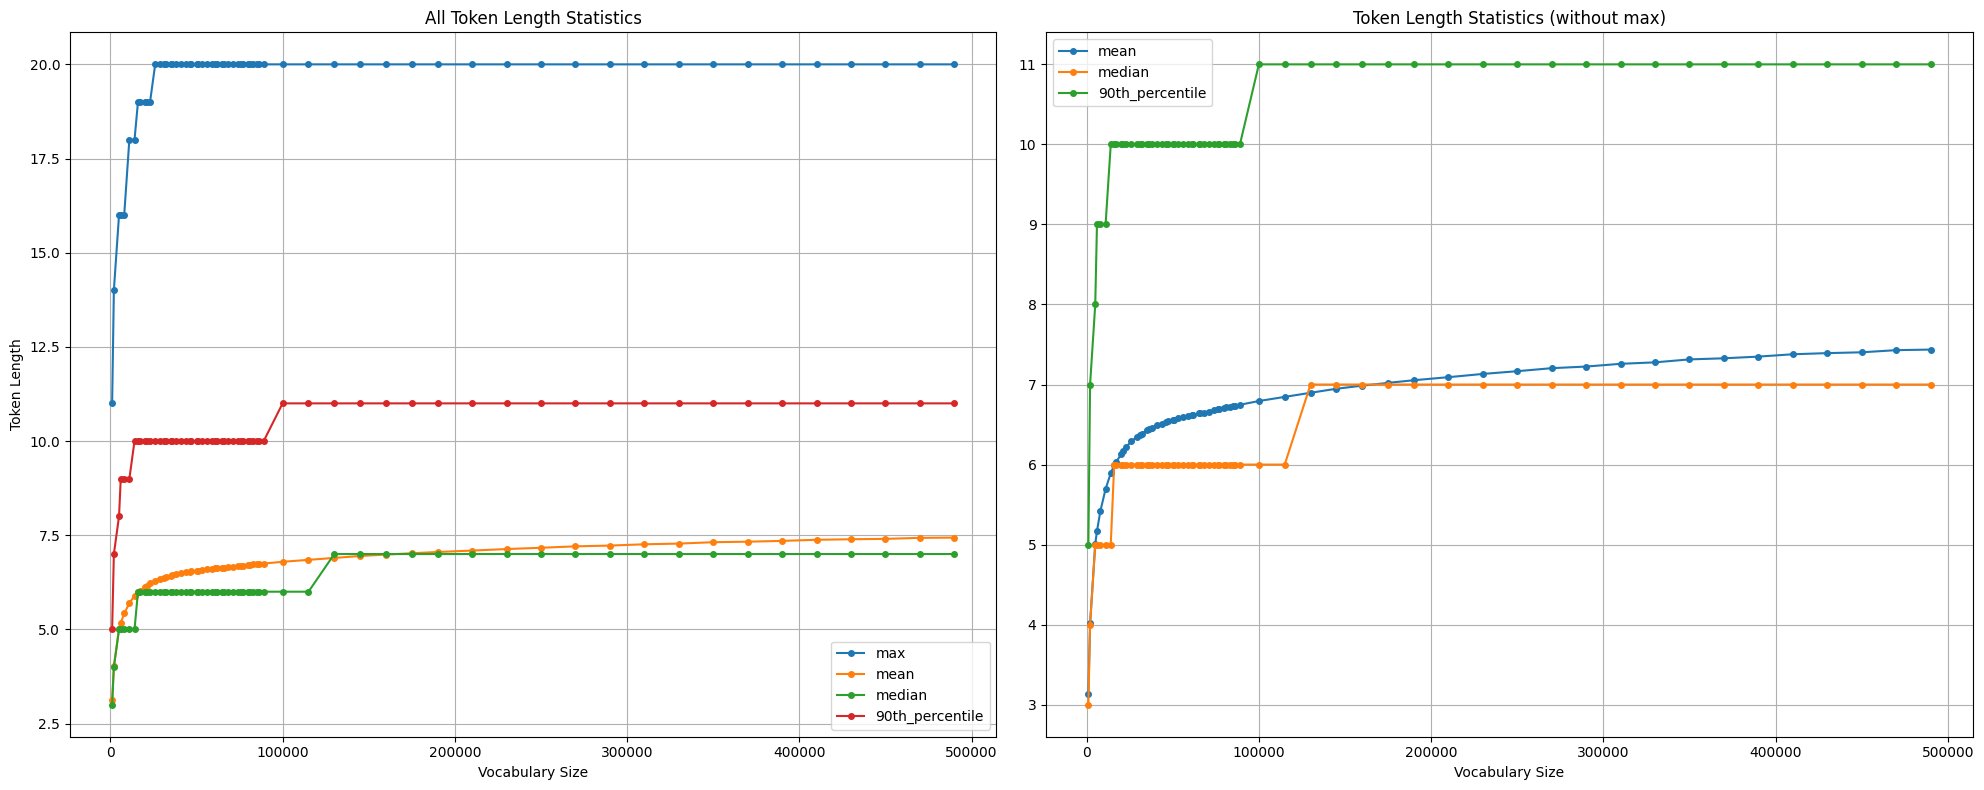

In [50]:
def plot_a_statistical_comparison_plot(vocab_size_dict, output_filename = None):
    stats = {
        'max': [],
        'mean': [],
        'median': [],
        '90th_percentile': []
    }
    vocab_sizes = []

    for vocab_len, token_lengths in vocab_size_dict.items():
        vocab_sizes.append(vocab_len)
        stats['max'].append(max(token_lengths))
        stats['mean'].append(np.mean(token_lengths))
        stats['median'].append(np.median(token_lengths))
        stats['90th_percentile'].append(np.percentile(token_lengths, 90))

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

    # First subplot with all statistics (including max)
    for stat_name, values in stats.items():
        ax1.plot(vocab_sizes, values, label=stat_name, marker='o', markersize=4)

    ax1.set_title("All Token Length Statistics")
    ax1.set_xlabel("Vocabulary Size")
    ax1.set_ylabel("Token Length")
    ax1.legend()
    ax1.grid(True)

    # Second subplot with all statistics except max
    for stat_name, values in stats.items():
        if stat_name != 'max':  # Skip the max statistic for the second plot
            ax2.plot(vocab_sizes, values, label=stat_name, marker='o', markersize=4)

    ax2.set_title("Token Length Statistics (without max)")
    ax2.set_xlabel("Vocabulary Size")
    ax2.legend()
    ax2.grid(True)

    # Ensure images directory exists
    os.makedirs("images", exist_ok=True)

    # Save the plot
    plt.tight_layout()
    if output_filename:
        plt.savefig(os.path.join("images", output_filename), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

plot_a_statistical_comparison_plot(big_data_vocab)

In [41]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import imageio.v2 as imageio          # ≥2.31 recommended
import io

# --- 1. Figure-building helper ---------------------------------------------
def build_comparison_figure(key, comparison_data, relative=False):
    fig, ax = plt.subplots(figsize=(16, 8))

    max_length = 0
    for name, vocab_collection in comparison_data.items():
        token_lengths = vocab_collection[key]
        max_length = max(max_length, max(token_lengths))
        counts = Counter(token_lengths)

        xs = np.array(sorted(counts))
        ys = np.array([counts[x] for x in xs])
        if relative:
            ys = ys / ys.sum()

        ax.plot(xs, ys, label=name, linewidth=2)

    max_length = 21 # min(20, max_length)
    ax.set(
        title=f"Distribution of token lengths – size {key:>8}",
        xlabel="Token length",
        ylabel="Relative count" if relative else "Count",
        xticks=range(0, max_length + 1),
    )
    ax.set_ylim(top=14000, bottom=-0.01)  
    ax.legend()
    ax.grid(True)
    return fig  # <-- return, don’t show


# --- 2. Loop over keys, collect PNG frames ---------------------------------
dicts = {
    "small_data": small_data_vocab,
    "big_data": big_data_vocab,
}

frames = []
for key in sorted(set(small_data_vocab) & set(big_data_vocab)):
    fig = build_comparison_figure(key, dicts, relative=False)

    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=100)   # <-  remove bbox_inches="tight"
    buf.seek(0)
    frames.append(imageio.imread(buf))
    plt.close(fig)


# --- 3. Write a single looping GIF -----------------------------------------
imageio.mimsave(
    "token_length_distributions.gif",  # output file
    frames,
    duration=1.5,   # seconds per frame
    loop=0,         # 0 = loop forever
)


Side-by-side plots created and saved to 'images/token_length_statistics_comparison.png'
